## Coding Practice #0506

#### 1. Document classification with LSTM network:

In [0]:
import pandas as pd
import numpy as np
import warnings    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.reuters import load_data, get_word_index       # Reuters news data. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data:

In [0]:
n_words = 1000                                        # Size of the vocabulary.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words, test_split = 0.3)
n_train_size = X_train.shape[0]

2113536/2110848 [==============================] - 0s 0us/step


In [0]:
# Check for the shapes.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (7859,)
Training data y shape: (7859,)
--------------------------------------------------
Test data X shape: (3369,)
Test data y shape: (3369,)
--------------------------------------------------


#### 1.2. Explore the data:

In [0]:
# Number of unique values of y = Number of categories of the newswires.
n_cat = pd.Series(y_train).nunique()
n_cat

46

In [0]:
# Print out an observation (document) contained in X.
# It is encoded as integers (indices).
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [0]:
# Let's check for length of the first 100 documents.
# We notice that the length is not uniform.
print([len(a) for a in X_train[0:100]])

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64]


In [0]:
# Download the dictionary to translate the indices.
my_dict = get_word_index(path='reuters_word_index.json')

557056/550378 [==============================] - 0s 0us/step


In [0]:
# To view the dictionary.
# my_dict

In [0]:
# Exchange the 'key' and 'value'.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [0]:
# Translate each document.
i_news = 10                                        # Document number that can be changed at will.
news = list(pd.Series(X_train[i_news]).apply(lambda x: my_dict_inv[x]))
print(' '.join(news))

the federal gain only growth lt they meeting year reuter company did year an they of of reuter company of of 1987 had of of reuter had profits of pct dlrs


#### 1.3. Data preprocessing:

In [0]:
# Padding: newswire lengths are uniformly matched to maxlen.
# Cut away if longer than maxlen and fill with 0s if shorter than maxlen.
X_train = sequence.pad_sequences(X_train, maxlen = 100)
X_test = sequence.pad_sequences(X_test, maxlen = 100)

In [0]:
# Apply one-hot-encoding to the y variable.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,46)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 1.4. Define the model:

In [0]:
n_neurons = 100                   # Neurons within each memory cell.
n_input = 100                     # Dimension of the embeding space. 

In [0]:
# LSTM network model.
my_model = Sequential()
my_model.add(Embedding(n_words, n_input))           # n_words = vocabulary size, n_input = dimension of the embedding space.
my_model.add(LSTM(units=n_neurons, return_sequences=False, input_shape=(None, n_input), activation='tanh'))
my_model.add(Dense(n_cat, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# View the summary.
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 46)                4646      
Total params: 185,046
Trainable params: 185,046
Non-trainable params: 0
_________________________________________________________________


#### 1.5. Define the optimizer and compile:

In [0]:
n_epochs = 20                      # Number of epochs.
batch_size = 20                    # Size of each batch.
learn_rate = 0.001                 # learning rate.  

In [0]:
# Optimizer and compilation.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 1.6. Train the model and visualize the history:

In [0]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6287 samples, validate on 1572 samples
Epoch 1/20
6287/6287 [==============================] - 47s 7ms/sample - loss: 2.3300 - acc: 0.4062 - val_loss: 1.9837 - val_acc: 0.4892
Epoch 2/20
6287/6287 [==============================] - 45s 7ms/sample - loss: 1.8113 - acc: 0.5368 - val_loss: 1.6759 - val_acc: 0.5751
Epoch 3/20
6287/6287 [==============================] - 45s 7ms/sample - loss: 1.6727 - acc: 0.5737 - val_loss: 1.7180 - val_acc: 0.5566
Epoch 4/20
6287/6287 [==============================] - 45s 7ms/sample - loss: 1.5603 - acc: 0.6046 - val_loss: 1.5064 - val_acc: 0.6234
Epoch 5/20
6287/6287 [==============================] - 46s 7ms/sample - loss: 1.5040 - acc: 0.6154 - val_loss: 1.4988 - val_acc: 0.6101
Epoch 6/20
6287/6287 [==============================] - 46s 7ms/sample - loss: 1.3814 - acc: 0.6434 - val_loss: 1.4094 - val_acc: 0.6387
Epoch 7/20
6287/6287 [==============

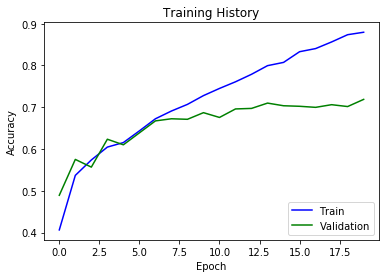

In [0]:
plt.plot(my_summary.history['acc'], c="b")
plt.plot(my_summary.history['val_acc'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 1.7. Testing: 

In [0]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.6890000104904175
